# Model#1  
<img src="Model1.png" width="800">

## Cell OCV curve

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

In [2]:
%config InlineBackend.figure_formats = {'png', 'retina'}
pd.set_option("display.max_rows", 10)

In [3]:
def DOD_norm(df, dod_s, dod_e):
    df = df - np.min(df)
    b = (dod_e - dod_s)/np.max(df)
    df = df*b
    df = df + dod_s
    return df

In [4]:
def dQdV(df_x, df_y, delta):
    dQ = abs(np.roll(df_x, delta) - np.roll(df_x, -delta))
    dV = abs(np.roll(df_y, delta) - np.roll(df_y, -delta))
    dQ = np.where(dQ <=0, np.nan, dQ)
    df_dQdV = dV/dQ
    df_dQdV[:delta] = np.nan
    df_dQdV[-delta:] = np.nan
    return df_dQdV

In [5]:
def smooth(df, delta):
    df_tmp = np.zeros((2*delta, len(df)))
    for i in range(delta):
        df_tmp[(i-1),:] = np.roll(df, i)
        df_tmp[(i-1+delta),:] = np.roll(df, -i)
    df_tmp2 = np.median(df_tmp, axis=0)
    df_tmp2[:delta] = np.nan
    df_tmp2[-delta:] = np.nan
    
    return df_tmp2

In [6]:
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

In [7]:
df_LCO_OCV = pd.read_csv('LCO_OCV1.csv')
df_LCO_OCV.columns = ['x', 'Potential(V)']
df_LCO_OCV = df_LCO_OCV.sort_values(by=['x'], ascending=False)
df_LCO_OCV = df_LCO_OCV.reset_index(drop=True)
df_LCO_OCV['x'] = 1-df_LCO_OCV['x']

df_LCO_OCV['x'] = smooth(df_LCO_OCV['x'],20)
df_LCO_OCV['Potential(V)'] = smooth(df_LCO_OCV['Potential(V)'], 20)
df_LCO_OCV = df_LCO_OCV.dropna()
df_LCO_OCV = df_LCO_OCV.sort_values(by=['x'], ascending=True)

In [8]:
df_LiC6_OCV = pd.read_csv('LiC6_OCV1.csv')
df_LiC6_OCV.columns = ['x', 'Potential(V)']
df_LiC6_OCV = df_LiC6_OCV.sort_values(by=['x'], ascending=False)
df_LiC6_OCV = df_LiC6_OCV.reset_index(drop=True)
df_LiC6_OCV['x'] = 1-df_LiC6_OCV['x']
df_LiC6_OCV['x'] = smooth(df_LiC6_OCV['x'],10)
df_LiC6_OCV['Potential(V)'] = smooth(df_LiC6_OCV['Potential(V)'], 10)
df_LiC6_OCV = df_LiC6_OCV.dropna()
df_LiC6_OCV = df_LiC6_OCV.sort_values(by=['x'], ascending=True)

In [9]:
df_LCO_OCV['x']  = DOD_norm(df_LCO_OCV['x'], -0.25, 1.05)
df_LiC6_OCV['x']  = DOD_norm(df_LiC6_OCV['x'], -0.0, 1)

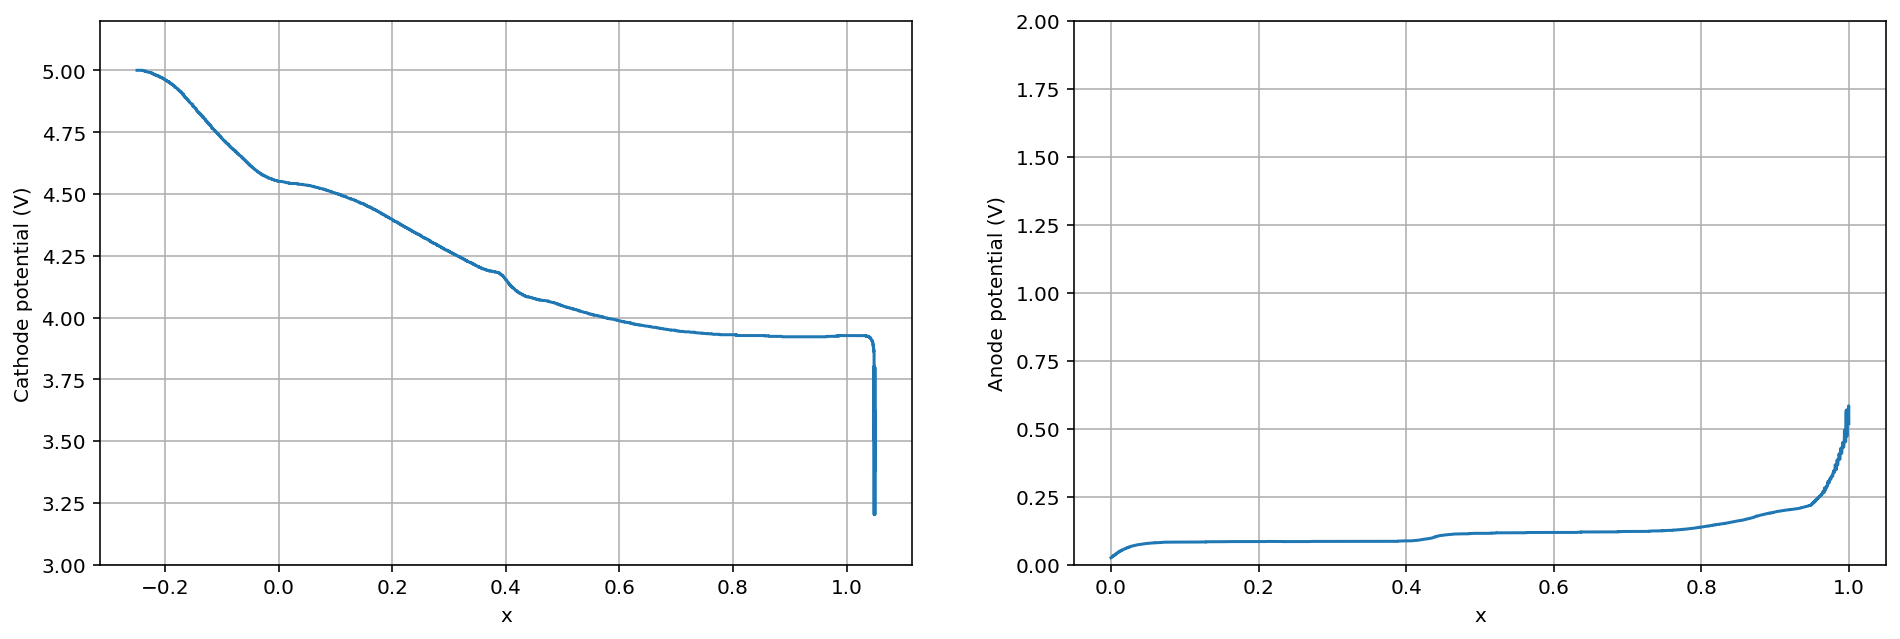

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(df_LCO_OCV['x'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5.2])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('x')
ax1.grid()

ax2.plot(df_LiC6_OCV['x'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('x')
ax2.grid()
plt.show()

In [11]:
df_cell = pd.DataFrame(np.arange(1001))/1000
df_cell.columns = ['x']
df_cell = pd.merge_asof(df_cell, df_LCO_OCV, on='x', direction='nearest')
df_cell = pd.merge_asof(df_cell, df_LiC6_OCV, on='x', direction='nearest')
df_cell.columns = ['x', 'Cathode OCV (V)', 'Anode OCV (V)']
df_cell

,x,Cathode OCV (V),Anode OCV (V)
0,0.000,4.55072,0.025321
1,0.001,4.55072,0.026563
2,0.002,4.55072,0.029359
3,0.003,4.55072,0.031378
4,0.004,4.55072,0.033863
...,...,...,...
996,0.996,3.92698,0.560382
997,0.997,3.92698,0.506488
998,0.998,3.92698,0.558674
999,0.999,3.92698,0.515807


In [12]:
df_cell['Cell OCV (V)'] = (df_cell['Cathode OCV (V)']  - df_cell['Anode OCV (V)'] )
df_cell

,x,Cathode OCV (V),Anode OCV (V),Cell OCV (V)
0,0.000,4.55072,0.025321,4.525399
1,0.001,4.55072,0.026563,4.524157
2,0.002,4.55072,0.029359,4.521361
3,0.003,4.55072,0.031378,4.519342
4,0.004,4.55072,0.033863,4.516857
...,...,...,...,...
996,0.996,3.92698,0.560382,3.366598
997,0.997,3.92698,0.506488,3.420492
998,0.998,3.92698,0.558674,3.368306
999,0.999,3.92698,0.515807,3.411173


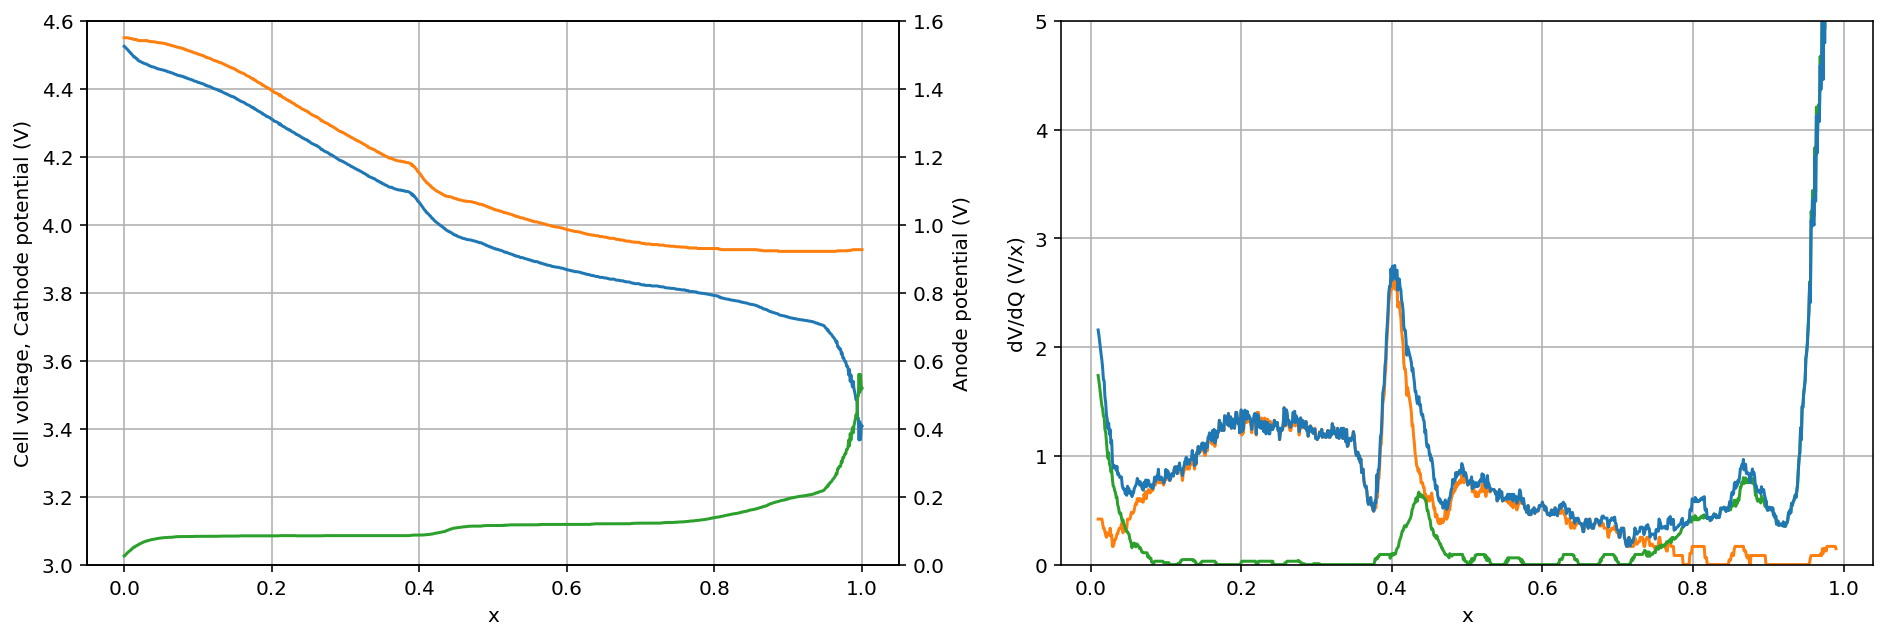

In [13]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))

ax2 = ax1.twinx()
ax1.plot(df_cell['x'], df_cell['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_cell['x'], df_cell['Cell OCV (V)'], color = new_colors[0])
ax1.set_ylabel('Cell voltage, Cathode potential (V)')
ax2.plot(df_cell['x'], df_cell['Anode OCV (V)'], color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('x')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])

ax1.grid()

ax3.plot(df_cell['x'], dQdV(df_cell['x'], df_cell['Cathode OCV (V)'], 10), color = new_colors[1])
ax3.plot(df_cell['x'], dQdV(df_cell['x'], df_cell['Anode OCV (V)'], 10), color = new_colors[2])
ax3.plot(df_cell['x'], dQdV(df_cell['x'], df_cell['Cell OCV (V)'], 10), color = new_colors[0])


ax3.set_ylabel('dV/dQ (V/x)')
ax3.set_xlabel('x')

ax3.set_ylim([0, 5])

ax3.grid(which='both')

plt.show()


## Overpotential by foil electronic resistance
\begin{eqnarray*}
\rho(T) = \rho_0[1+\alpha(T-T_0)]
\end{eqnarray*}

In [14]:
#resistivity at 294.15K (20deg.C)
rho_0_Al = 2.82E-8#[ohm m]
rho_0_Cu = 1.68E-8#[ohm m]
alpha_Al = 0.0039#[/K]
alpha_Cu = 0.003862#[/K]

In [15]:
#Temperature
T = 298#[K]
temp_0 = 23 + 273.15#[K]

In [36]:
#Dimension
L1 = 100E-6#[m]
L2 = 200E-6#[m]
L3 = 300E-6#[m]
L4 = 400E-6#[m]
L5 = 500E-6#[m]
M = 100E-6#[m]
N = 100E-6#[m]
S = M * N#[m2]

In [17]:
#Current
I = 5E-7#[A]
print(I/S)#[A/m2]

50.0


In [18]:
Al_length = L1
Cu_length = L5 - L4

In [19]:
#Overpotential by foil resistance
DV_Al = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * Al_length / S *I
DV_Cu = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * Cu_length / S *I
print(DV_Al)
print(DV_Cu)

1.4201731500000005e-10
8.46001548e-11


## Overpotential by Butler-volmer equation

\begin{eqnarray*}
j = j_0 \left( \exp \left[\frac{\alpha_a zF\eta}{RT}\right] - \exp \left[-\frac{\alpha_c zF\eta}{RT}\right]\right)
\end{eqnarray*}

In [20]:
R = 8.3144598#[J/(mol K)]
F = 96485.33289#[C/mol]
z = 1
alpha=0.5
j_0_p = 2.6E1#[A/m2]
j_0_n = 3.6E1#[A/m2]
T = 298#[K]

In [21]:
eta = ((np.arange(101))-50)/400

In [22]:
j_p = j_0_p*(np.exp((alpha * z * F * eta) / (R*T)) - np.exp(-1*((1 - alpha) * z * F * eta) / (R*T)))
j_n = j_0_n*(np.exp((alpha * z * F * eta) / (R*T)) - np.exp(-1*((1 - alpha) * z * F * eta) / (R*T)))

In [23]:
j_p_c = j_0_p*(- np.exp(-1*((1 - alpha) * z * F * eta) / (R*T)))
j_p_a = j_0_p*(np.exp((alpha * z * F * eta) / (R*T)))

In [24]:
j_n_c = j_0_n*(- np.exp(-1*((1 - alpha) * z * F * eta) / (R*T)))
j_n_a = j_0_n*(np.exp((alpha * z * F * eta) / (R*T)))

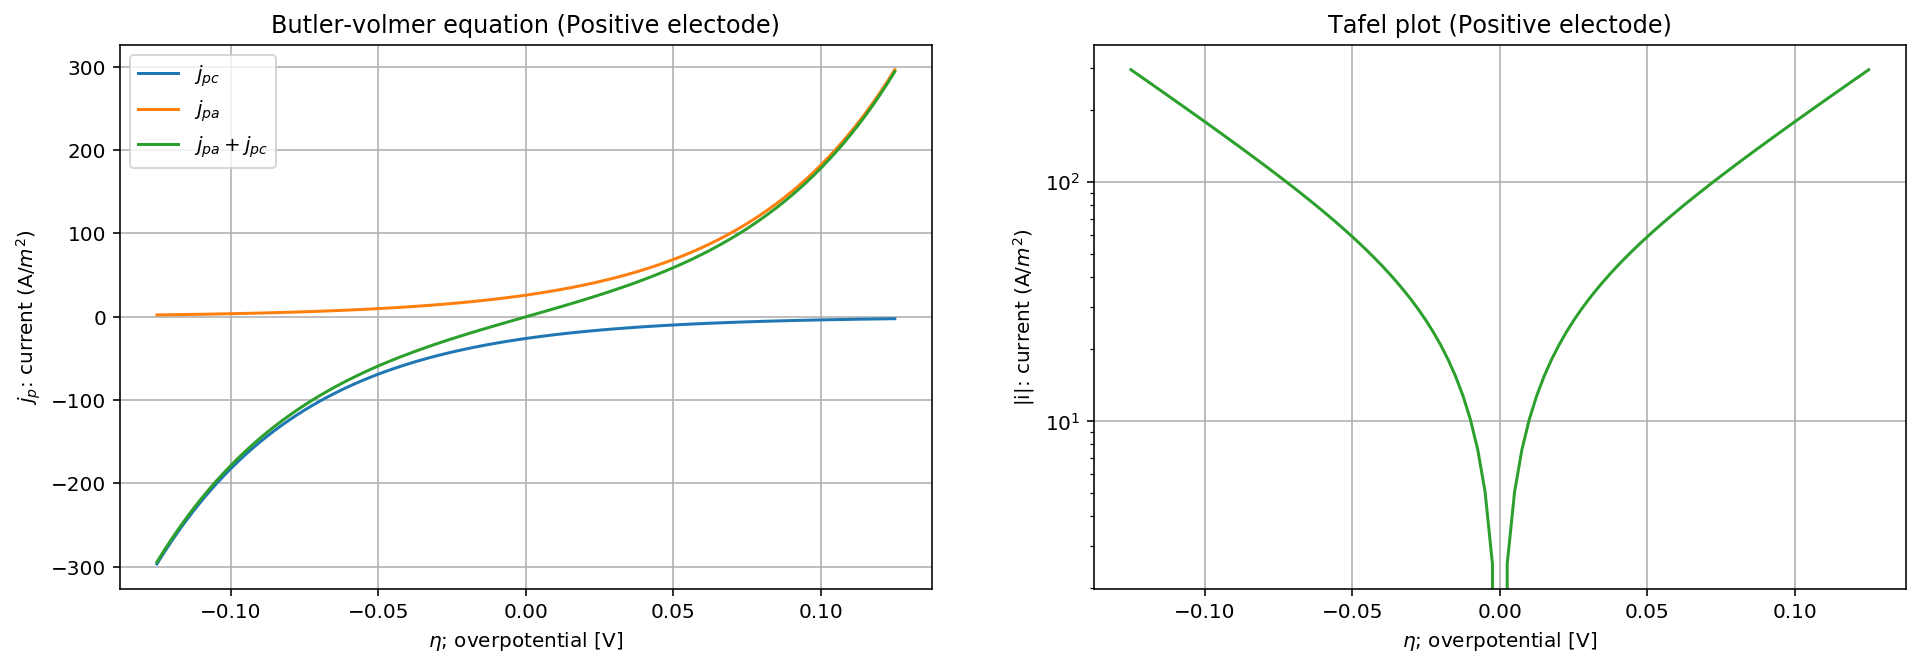

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(eta, (j_p_c), label = '$j_{pc}$', color=new_colors[0])
ax1.plot(eta, (j_p_a), label = '$j_{pa}$', color=new_colors[1])
ax1.plot(eta, (j_p_c + j_p_a), label = '$j_{pa} + j_{pc}$', color=new_colors[2])


#ax1.set_yscale('log')
ax1.grid()

ax1.set_ylabel('$j_p$: current (A/$m^2$)')
ax1.set_xlabel('$\eta$; overpotential [V]')
ax1.legend()
ax1.set_title('Butler-volmer equation (Positive electode)')


ax2.plot(eta, abs(j_p_c + j_p_a), color=new_colors[2])
ax2.set_yscale('log')
ax2.grid()

ax2.set_ylabel('|i|: current (A/$m^2$)')
ax2.set_xlabel('$\eta$; overpotential [V]')
ax2.set_title('Tafel plot (Positive electode)')

plt.show()



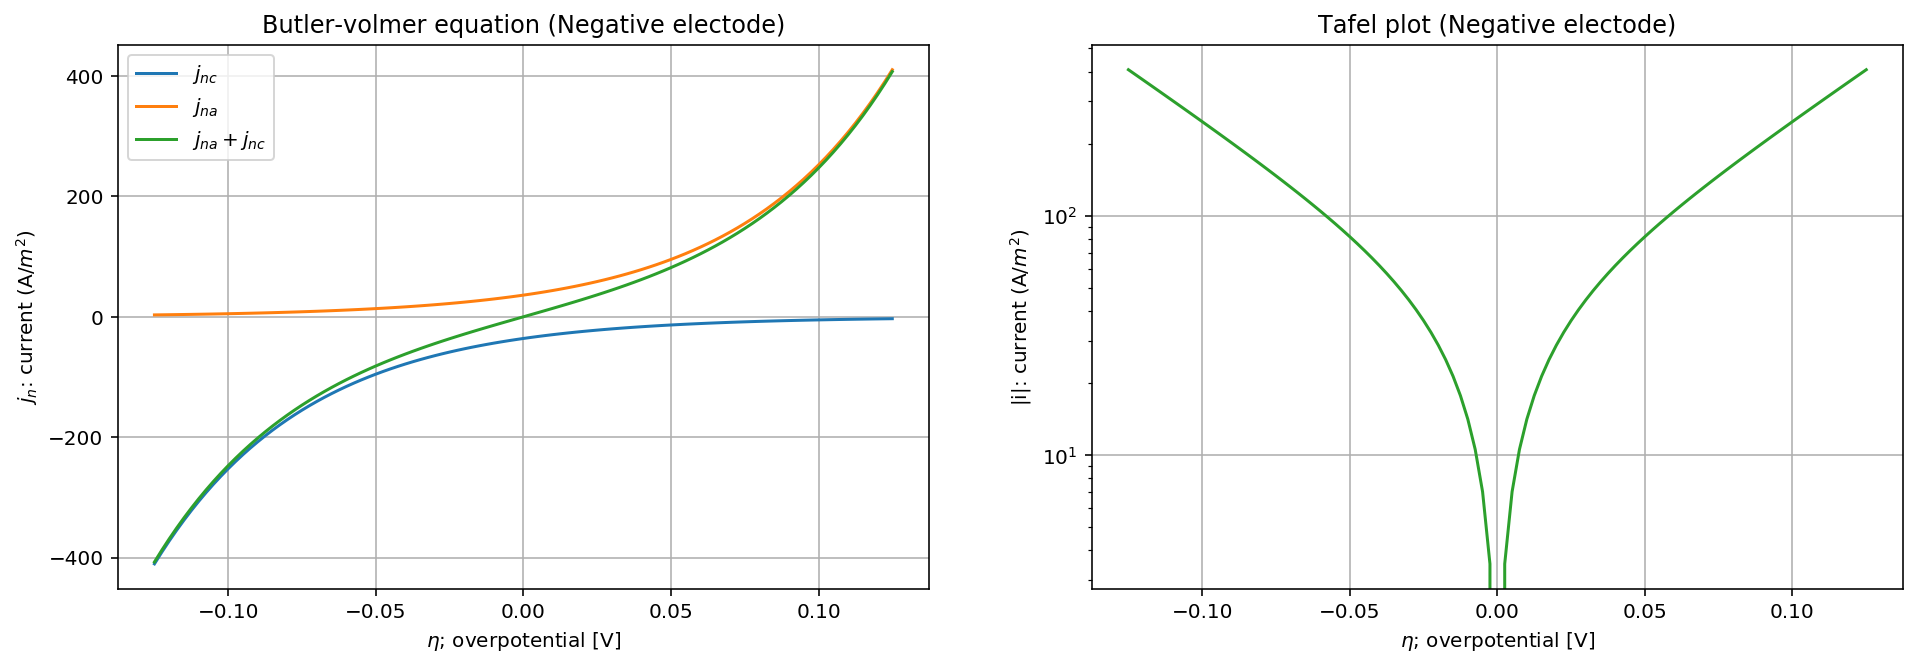

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(eta, (j_n_c), label = '$j_{nc}$', color=new_colors[0])
ax1.plot(eta, (j_n_a), label = '$j_{na}$', color=new_colors[1])
ax1.plot(eta, (j_n_c + j_n_a), label = '$j_{na} + j_{nc}$', color=new_colors[2])


#ax1.set_yscale('log')
ax1.grid()

ax1.set_ylabel('$j_n$: current (A/$m^2$)')
ax1.set_xlabel('$\eta$; overpotential [V]')
ax1.legend()
ax1.set_title('Butler-volmer equation (Negative electode)')


ax2.plot(eta, abs(j_n_c + j_n_a), color=new_colors[2])
ax2.set_yscale('log')
ax2.grid()

ax2.set_ylabel('|i|: current (A/$m^2$)')
ax2.set_xlabel('$\eta$; overpotential [V]')
ax2.set_title('Tafel plot (Negative electode)')

plt.show()




\begin{eqnarray*}
\eta = \frac{RT}{\alpha zF}ln\left(\frac{j}{2j_0} + \sqrt{\left(\frac{j}{2j_0}\right)^2 + 1} \right)
\end{eqnarray*}

In [27]:
j = ((np.arange(1001))-500)+0.1
j

array([-499.9, -498.9, -497.9, ...,  498.1,  499.1,  500.1])

In [28]:
eta_p = (R*T)/(alpha*z*F)*np.log(j/(2*j_0_p) + ((j/(2*j_0_p))**2 + 1)**0.5)
eta_n = (R*T)/(alpha*z*F)*np.log(j/(2*j_0_n) + ((j/(2*j_0_n))**2 + 1)**0.5)

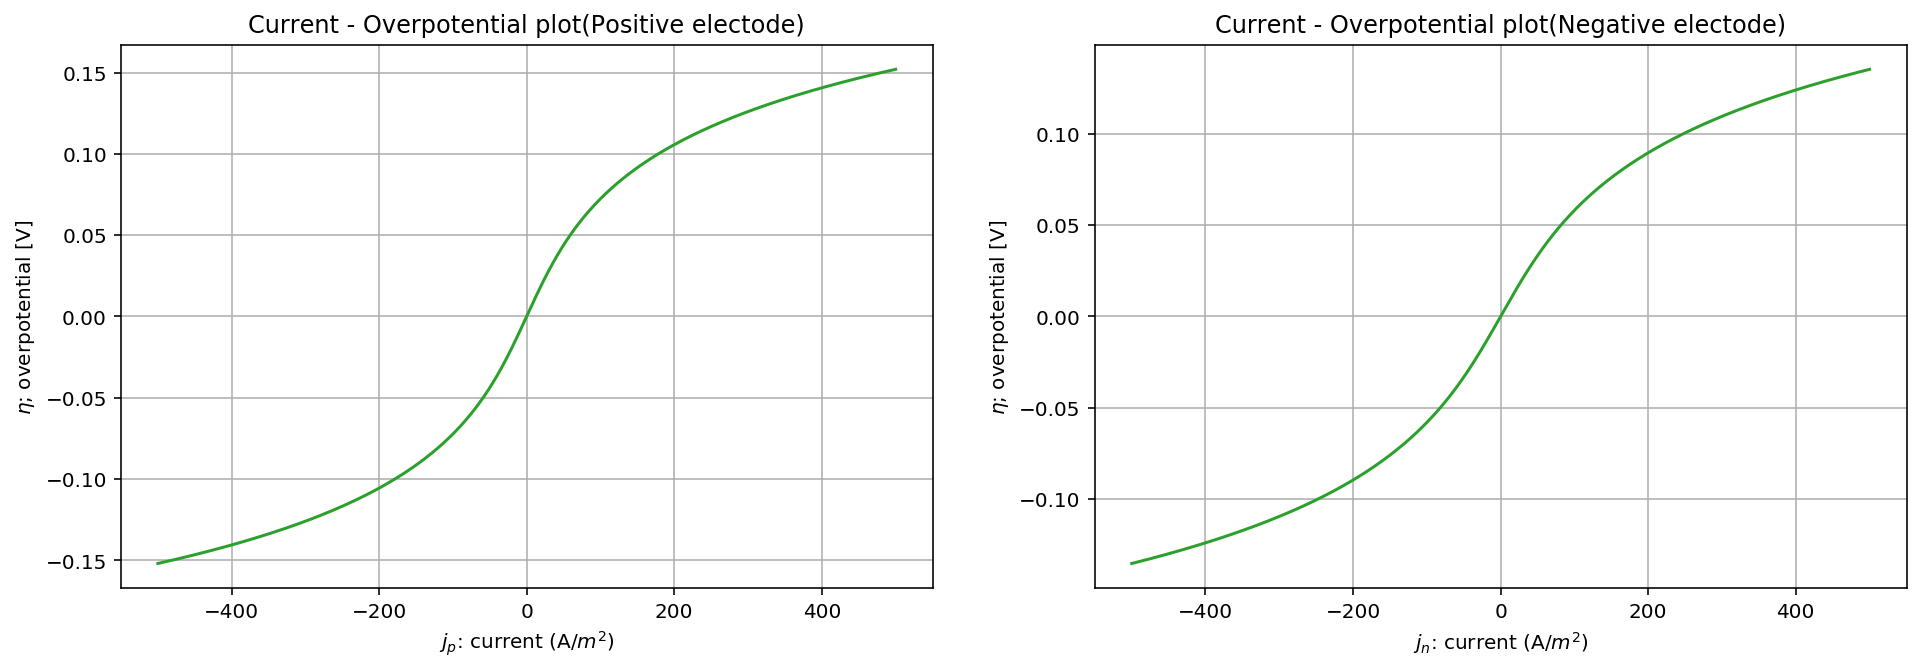

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(j, eta_p, color=new_colors[2])
ax1.grid()

ax1.set_xlabel('$j_p$: current (A/$m^2$)')
ax1.set_ylabel('$\eta$; overpotential [V]')
ax1.set_title('Current - Overpotential plot(Positive electode)')

ax2.plot(j, eta_n, color=new_colors[2])
ax2.grid()

ax2.set_xlabel('$j_n$: current (A/$m^2$)')
ax2.set_ylabel('$\eta$; overpotential [V]')
ax2.set_title('Current - Overpotential plot(Negative electode)')

plt.show()

## Cell CCV curve simulation

In [30]:
df_cell

,x,Cathode OCV (V),Anode OCV (V),Cell OCV (V)
0,0.000,4.55072,0.025321,4.525399
1,0.001,4.55072,0.026563,4.524157
2,0.002,4.55072,0.029359,4.521361
3,0.003,4.55072,0.031378,4.519342
4,0.004,4.55072,0.033863,4.516857
...,...,...,...,...
996,0.996,3.92698,0.560382,3.366598
997,0.997,3.92698,0.506488,3.420492
998,0.998,3.92698,0.558674,3.368306
999,0.999,3.92698,0.515807,3.411173


In [31]:
#resistivity at 294.15K (20deg.C)
rho_0_Al = 2.82E-8#[ohm m]
rho_0_Cu = 1.68E-8#[ohm m]
alpha_Al = 0.0039#[/K]
alpha_Cu = 0.003862#[/K]

#Temperature
T = 298#[K]
temp_0 = 23 + 273.15#[K]

#Dimension
L1 = 100E-6#[m]
L2 = 200E-6#[m]
L3 = 300E-6#[m]
L4 = 400E-6#[m]
L5 = 500E-6#[m]
M = 100E-6#[m]
N = 100E-6#[m]
S = M * N#[m2]

Al_length = L1
Cu_length = L5 - L4

#Current
I = 5E-7#[A]
j = I/S
#Constant
R = 8.3144598#[J/(mol K)]
F = 96485.33289#[C/mol]
z = 1
alpha=0.5
j_0_p = 2.6E1#[A/m2]
j_0_n = 3.6E1#[A/m2]


In [32]:
df_cell['DV_Al'] = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * Al_length / S *I
df_cell['DV_Cu'] = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * Cu_length / S *I

In [33]:
#Overpotential by charge transfer 
df_cell['DV_eta_p'] = (R*T)/(alpha*z*F)*np.log(j/(2*j_0_p) + ((j/(2*j_0_p))**2 + 1)**0.5)

df_cell['DV_eta_n'] = (R*T)/(alpha*z*F)*np.log(j/(2*j_0_n) + ((j/(2*j_0_n))**2 + 1)**0.5)
df_cell

,x,Cathode OCV (V),Anode OCV (V),Cell OCV (V),DV_Al,DV_Cu,DV_eta_p,DV_eta_n
0,0.000,4.55072,0.025321,4.525399,1.420173e-10,8.460015e-11,0.043856,0.033286
1,0.001,4.55072,0.026563,4.524157,1.420173e-10,8.460015e-11,0.043856,0.033286
2,0.002,4.55072,0.029359,4.521361,1.420173e-10,8.460015e-11,0.043856,0.033286
3,0.003,4.55072,0.031378,4.519342,1.420173e-10,8.460015e-11,0.043856,0.033286
4,0.004,4.55072,0.033863,4.516857,1.420173e-10,8.460015e-11,0.043856,0.033286
...,...,...,...,...,...,...,...,...
996,0.996,3.92698,0.560382,3.366598,1.420173e-10,8.460015e-11,0.043856,0.033286
997,0.997,3.92698,0.506488,3.420492,1.420173e-10,8.460015e-11,0.043856,0.033286
998,0.998,3.92698,0.558674,3.368306,1.420173e-10,8.460015e-11,0.043856,0.033286
999,0.999,3.92698,0.515807,3.411173,1.420173e-10,8.460015e-11,0.043856,0.033286


In [34]:
df_cell['Cathode CCV (V)'] = df_cell['Cathode OCV (V)']  - df_cell['DV_Al'] - df_cell['DV_eta_p']
df_cell['Anode CCV (V)'] = df_cell['Anode OCV (V)']  + df_cell['DV_Cu'] + df_cell['DV_eta_n']
df_cell['Cell CCV (V)'] = df_cell['Cathode CCV (V)'] - df_cell['Anode CCV (V)']


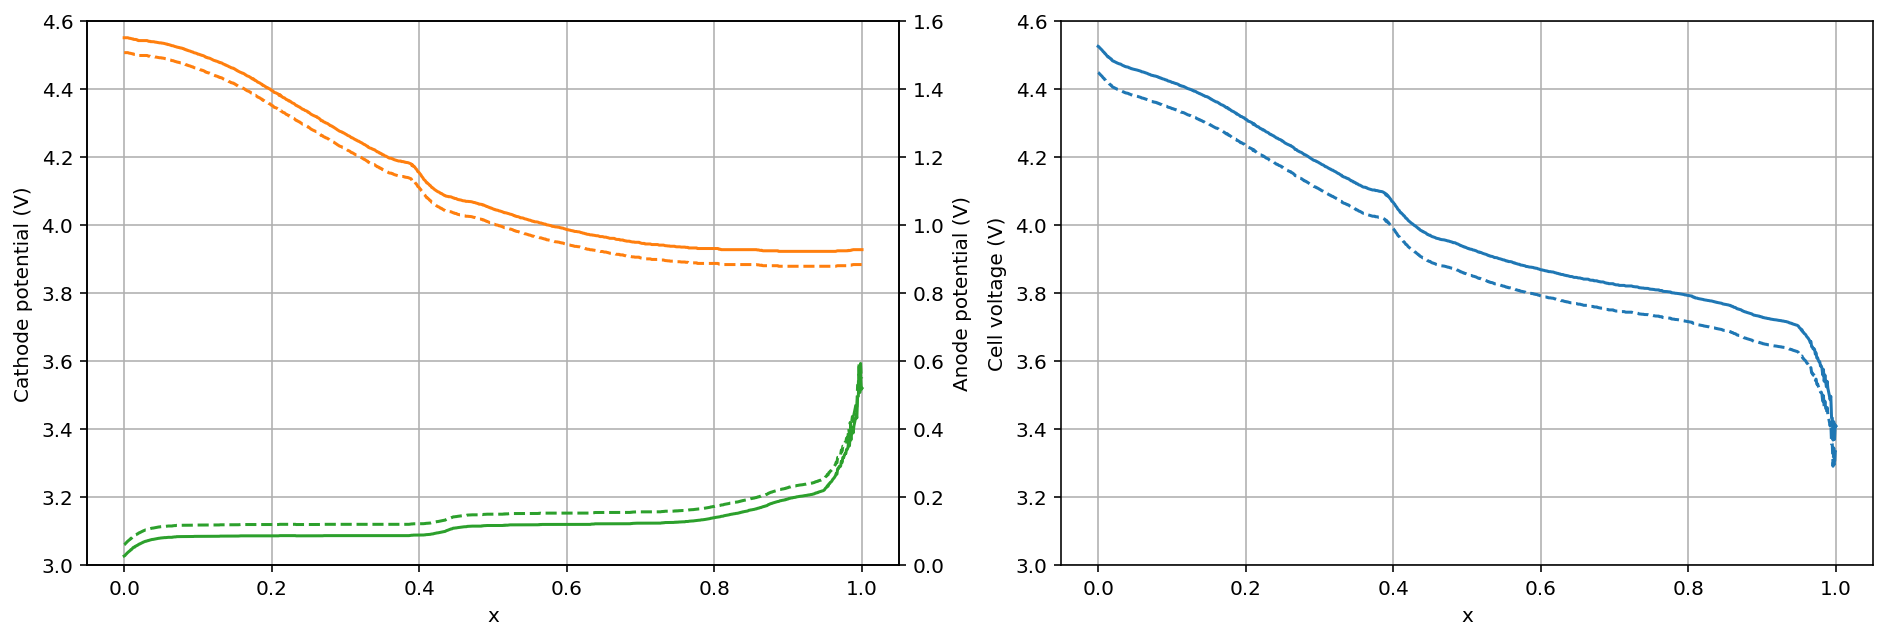

In [35]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))

ax2 = ax1.twinx()
ax1.plot(df_cell['x'], df_cell['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_cell['x'], df_cell['Cathode CCV (V)'],'--', color = new_colors[1])
ax1.set_ylabel('Cathode potential (V)')
ax2.plot(df_cell['x'], df_cell['Anode OCV (V)'], color = new_colors[2])
ax2.plot(df_cell['x'], df_cell['Anode CCV (V)'],'--', color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('x')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])
ax1.grid()



ax3.plot(df_cell['x'], df_cell['Cell OCV (V)'], color = new_colors[0])
ax3.plot(df_cell['x'], df_cell['Cell CCV (V)'],'--', color = new_colors[0])
ax3.set_ylabel('Cell voltage (V)')
ax3.set_xlabel('x')
ax3.set_ylim([3, 4.6])

ax3.grid()

plt.show()

